In [13]:
# Author: Andrea Pierré
# License: MIT License

!pip install gymnasium
from pathlib import Path
from typing import NamedTuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map


sns.set_theme()

# %load_ext lab_black

In [14]:
class Params(NamedTuple):
    total_episodes: int  # Total episodes
    learning_rate: float  # Learning rate
    gamma: float  # Discounting rate
    epsilon: float  # Exploration probability
    map_size: int  # Number of tiles of one side of the squared environment
    seed: int  # Define a seed so that we get reproducible results
    is_slippery: bool  # If true the player will move in intended direction with probability of 1/3 else will move in either perpendicular direction with equal probability of 1/3 in both directions
    n_runs: int  # Number of runs
    action_size: int  # Number of possible actions
    state_size: int  # Number of possible states
    proba_frozen: float  # Probability that a tile is frozen
    savefig_folder: Path  # Root folder where plots are saved


params = Params(
    total_episodes=2000,
    learning_rate=0.8,
    gamma=0.95,
    epsilon=0.1,
    map_size=5,
    seed=123,
    is_slippery=False,
    n_runs=20,
    action_size=None,
    state_size=None,
    proba_frozen=0.9,
    savefig_folder=Path("../../_static/img/tutorials/"),
)
params

# Set the seed
rng = np.random.default_rng(params.seed)

# Create the figure folder if it doesn't exist
params.savefig_folder.mkdir(parents=True, exist_ok=True)

In [15]:
env = gym.make(
    "FrozenLake-v1",
    is_slippery=params.is_slippery,
    render_mode="rgb_array",
    desc=generate_random_map(
        size=params.map_size, p=params.proba_frozen, seed=params.seed
    ),
)

In [16]:
params = params._replace(action_size=env.action_space.n)
params = params._replace(state_size=env.observation_space.n)
print(f"Action size: {params.action_size}")
print(f"State size: {params.state_size}")


class Qlearning:
    def __init__(self, learning_rate, gamma, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.reset_qtable()

    def update(self, state, action, reward, new_state):
        """Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]"""
        delta = (
            reward
            + self.gamma * np.max(self.qtable[new_state, :])
            - self.qtable[state, action]
        )
        q_update = self.qtable[state, action] + self.learning_rate * delta
        return q_update

    def reset_qtable(self):
        """Reset the Q-table."""
        self.qtable = np.zeros((self.state_size, self.action_size))


class EpsilonGreedy:
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def choose_action(self, action_space, state, qtable):
        """Choose an action `a` in the current world state (s)."""
        # First we randomize a number
        explor_exploit_tradeoff = rng.uniform(0, 1)

        # Exploration
        if explor_exploit_tradeoff < self.epsilon:
            action = action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        else:
            # Break ties randomly
            # Find the indices where the Q-value equals the maximum value
            # Choose a random action from the indices where the Q-value is maximum
            max_ids = np.where(qtable[state, :] == max(qtable[state, :]))[0]
            action = rng.choice(max_ids)
        return action

Action size: 4
State size: 25


In [17]:
learner = Qlearning(
    learning_rate=params.learning_rate,
    gamma=params.gamma,
    state_size=params.state_size,
    action_size=params.action_size,
)
explorer = EpsilonGreedy(
    epsilon=params.epsilon,
)

In [18]:
def postprocess(episodes, params, rewards, steps, map_size):
    """Convert the results of the simulation in dataframes."""
    res = pd.DataFrame(
        data={
            "Episodes": np.tile(episodes, reps=params.n_runs),
            "Rewards": rewards.flatten(order="F"),
            "Steps": steps.flatten(order="F"),
        }
    )
    res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
    res["map_size"] = np.repeat(f"{map_size}x{map_size}", res.shape[0])

    st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})
    st["map_size"] = np.repeat(f"{map_size}x{map_size}", st.shape[0])
    return res, st

In [19]:
def qtable_directions_map(qtable, map_size):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            # Assign an arrow only if a minimal Q-value has been learned as best action
            # otherwise since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

In [20]:
def plot_q_values_map(qtable, env, map_size):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    img_title = f"frozenlake_q_values_{map_size}x{map_size}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

In [21]:
def plot_states_actions_distribution(states, actions, map_size):
    """Plot the distributions of states and actions."""
    labels = {"LEFT": 0, "DOWN": 1, "RIGHT": 2, "UP": 3}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.histplot(data=states, ax=ax[0], kde=True)
    ax[0].set_title("States")
    sns.histplot(data=actions, ax=ax[1])
    ax[1].set_xticks(list(labels.values()), labels=labels.keys())
    ax[1].set_title("Actions")
    fig.tight_layout()
    img_title = f"frozenlake_states_actions_distrib_{map_size}x{map_size}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

In [23]:
def run_env():
    rewards = np.zeros((params.total_episodes, params.n_runs))
    steps = np.zeros((params.total_episodes, params.n_runs))
    episodes = np.arange(params.total_episodes)
    qtables = np.zeros((params.n_runs, params.state_size, params.action_size))
    all_states = []
    all_actions = []

    for run in range(params.n_runs):  # Run several times to account for stochasticity
        learner.reset_qtable()  # Reset the Q-table between runs

        for episode in tqdm(
            episodes, desc=f"Run {run}/{params.n_runs} - Episodes", leave=False
        ):
            state = env.reset(seed=params.seed)[0]  # Reset the environment
            step = 0
            done = False
            total_rewards = 0

            while not done:
                action = explorer.choose_action(
                    action_space=env.action_space, state=state, qtable=learner.qtable
                )

                # Log all states and actions
                all_states.append(state)
                all_actions.append(action)

                # Take the action (a) and observe the outcome state(s') and reward (r)
                new_state, reward, terminated, truncated, info = env.step(action)

                done = terminated or truncated

                learner.qtable[state, action] = learner.update(
                    state, action, reward, new_state
                )

                total_rewards += reward
                step += 1

                # Our new state is state
                state = new_state

            # Log all rewards and steps
            rewards[episode, run] = total_rewards
            steps[episode, run] = step
        qtables[run, :, :] = learner.qtable

    return rewards, steps, episodes, qtables, all_states, all_actions

def plot_states_actions_distribution(states, actions, map_size):
    """Plot the distributions of states and actions."""
    labels = {"LEFT": 0, "DOWN": 1, "RIGHT": 2, "UP": 3}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.histplot(data=states, ax=ax[0], kde=True)
    ax[0].set_title("States")
    sns.histplot(data=actions, ax=ax[1])
    ax[1].set_xticks(list(labels.values()), labels=labels.keys())
    ax[1].set_title("Actions")
    fig.tight_layout()
    img_title = f"frozenlake_states_actions_distrib_{map_size}x{map_size}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

Map size: 4x4


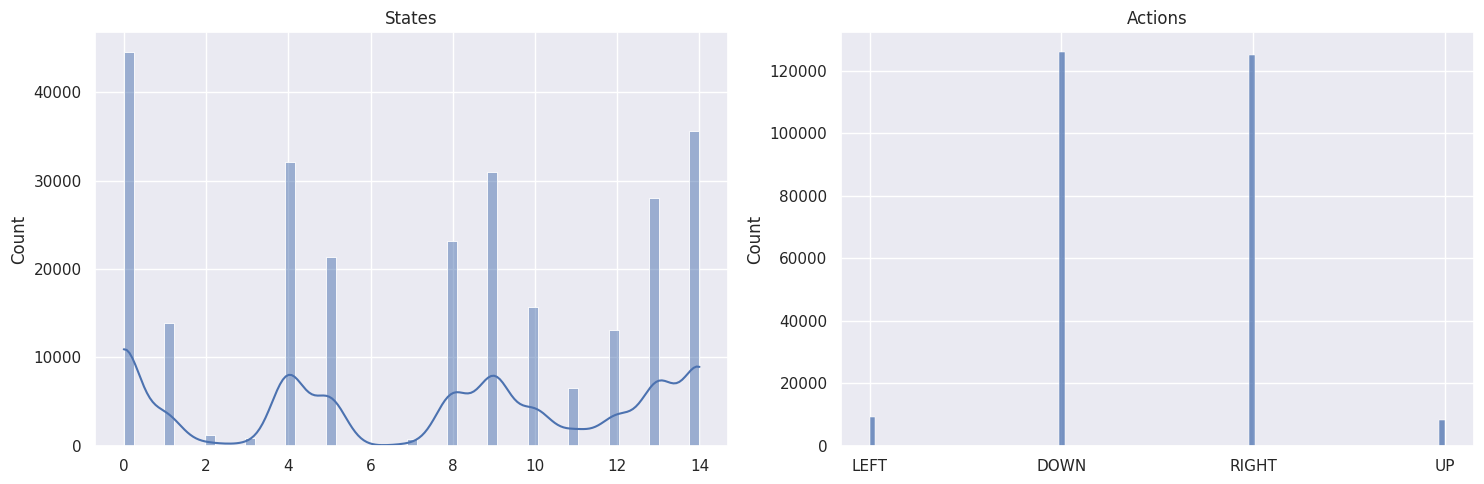

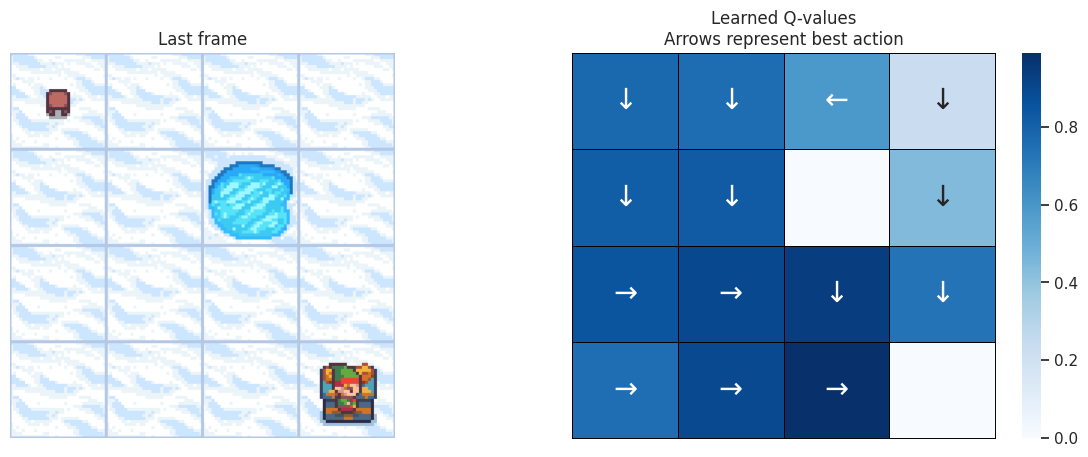

Map size: 7x7


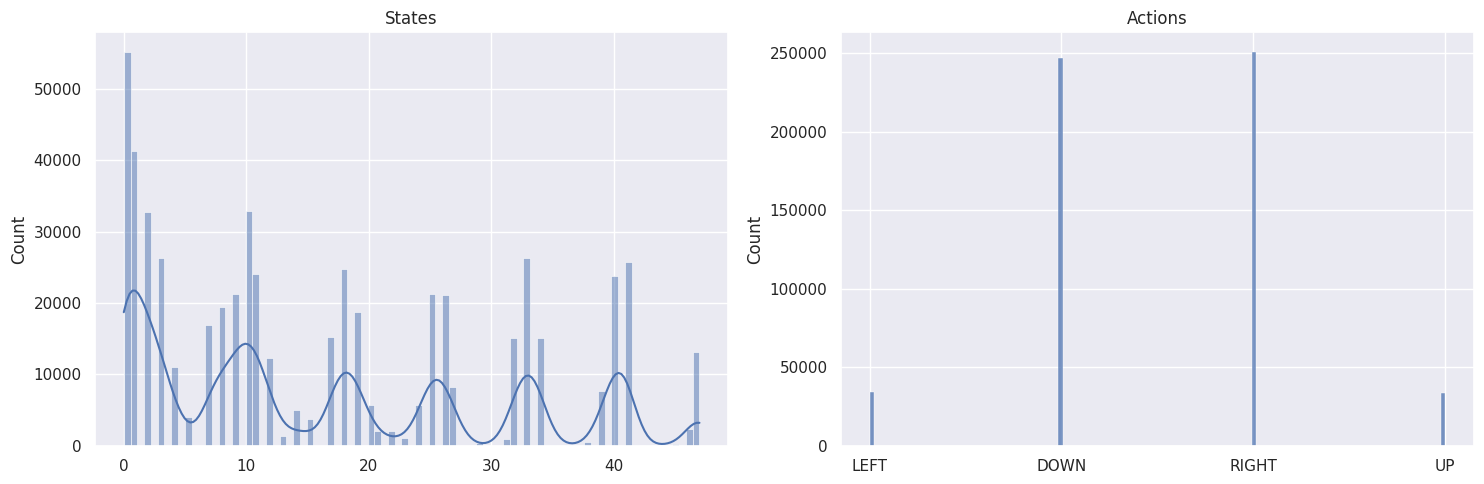

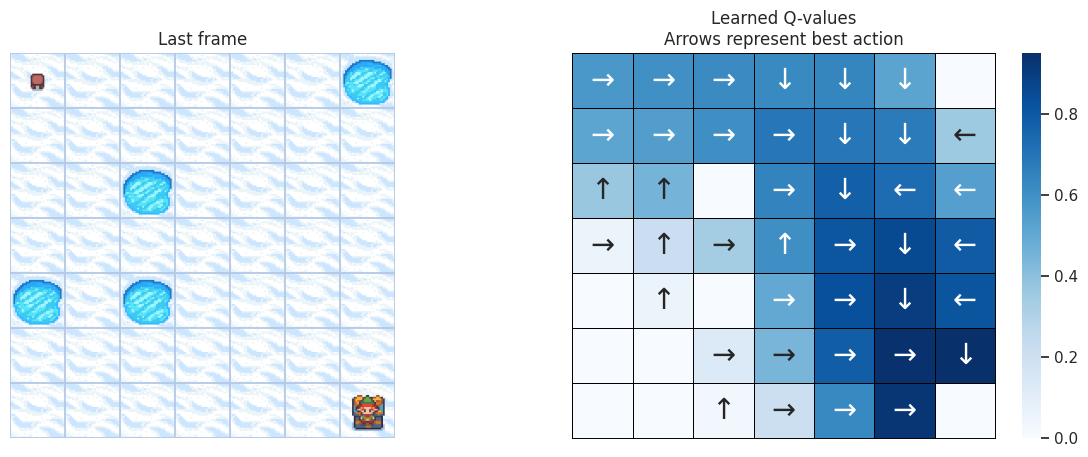

Map size: 9x9


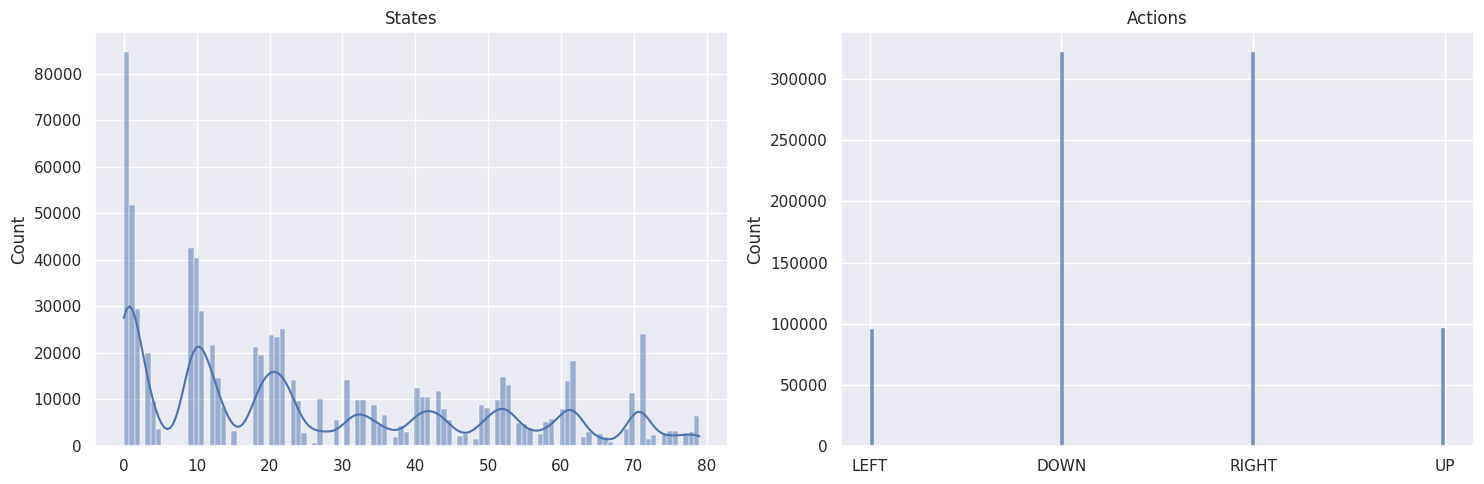

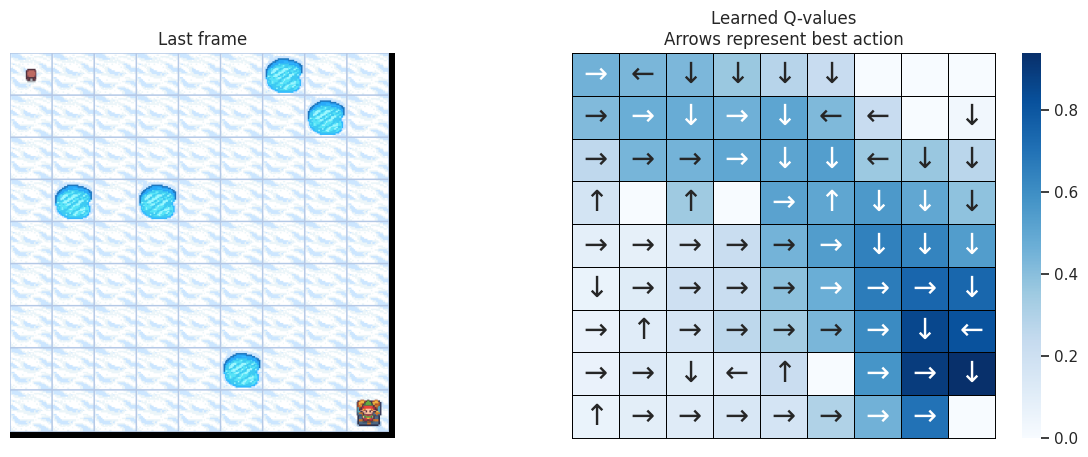

Map size: 11x11


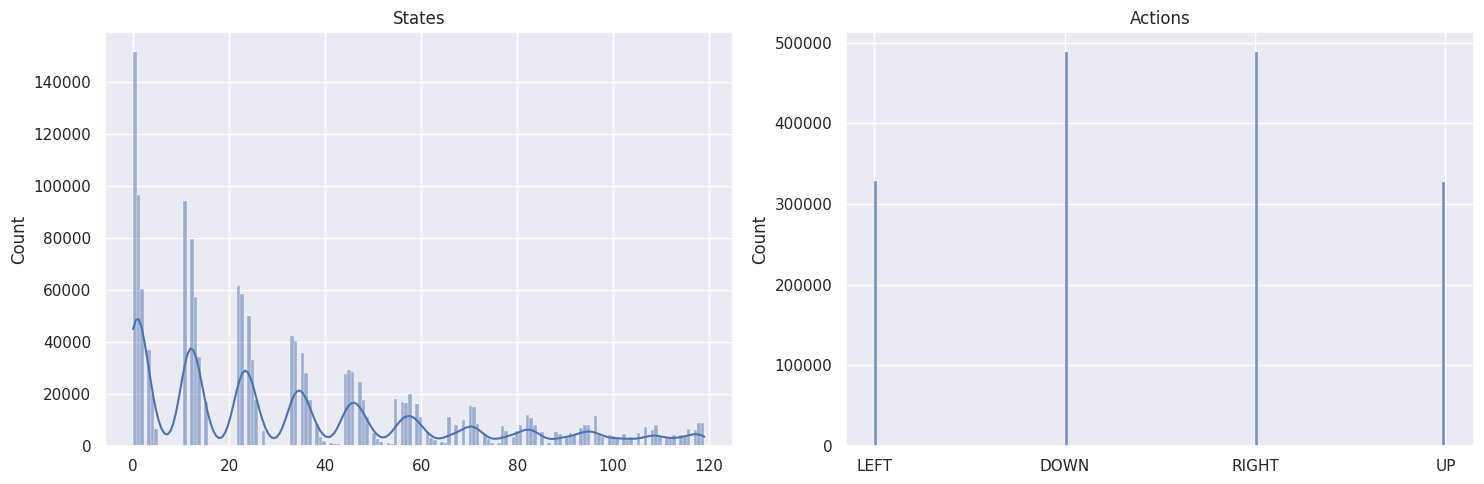

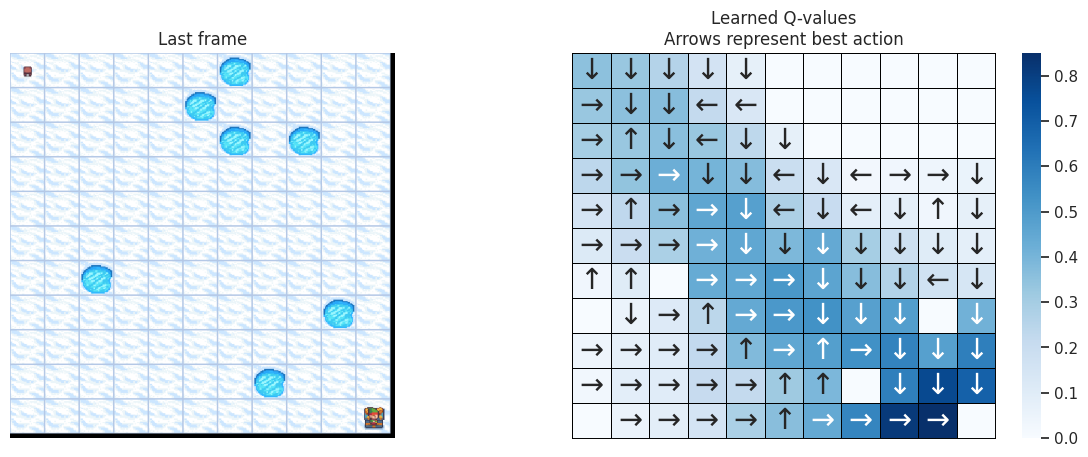

In [24]:
map_sizes = [4, 7, 9, 11]
res_all = pd.DataFrame()
st_all = pd.DataFrame()

for map_size in map_sizes:
    env = gym.make(
        "FrozenLake-v1",
        is_slippery=params.is_slippery,
        render_mode="rgb_array",
        desc=generate_random_map(
            size=map_size, p=params.proba_frozen, seed=params.seed
        ),
    )

    params = params._replace(action_size=env.action_space.n)
    params = params._replace(state_size=env.observation_space.n)
    env.action_space.seed(
        params.seed
    )  # Set the seed to get reproducible results when sampling the action space
    learner = Qlearning(
        learning_rate=params.learning_rate,
        gamma=params.gamma,
        state_size=params.state_size,
        action_size=params.action_size,
    )
    explorer = EpsilonGreedy(
        epsilon=params.epsilon,
    )

    print(f"Map size: {map_size}x{map_size}")
    rewards, steps, episodes, qtables, all_states, all_actions = run_env()

    # Save the results in dataframes
    res, st = postprocess(episodes, params, rewards, steps, map_size)
    res_all = pd.concat([res_all, res])
    st_all = pd.concat([st_all, st])
    qtable = qtables.mean(axis=0)  # Average the Q-table between runs

    plot_states_actions_distribution(
        states=all_states, actions=all_actions, map_size=map_size
    )  # Sanity check
    plot_q_values_map(qtable, env, map_size)

    env.close()

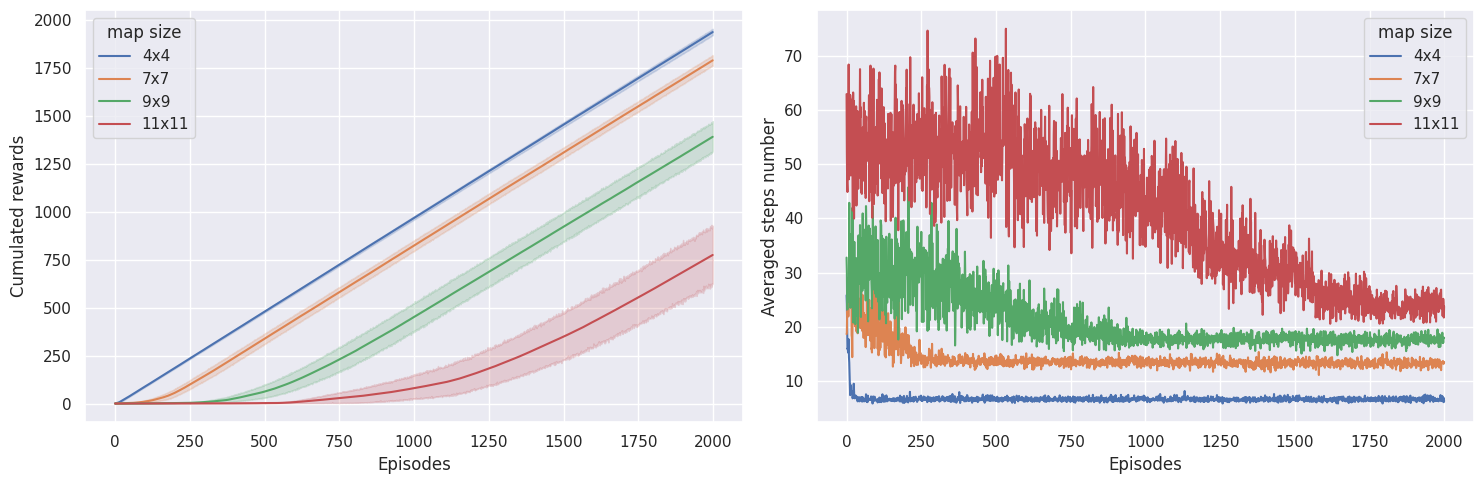

In [26]:
def plot_steps_and_rewards(rewards_df, steps_df):
    """Plot the steps and rewards from dataframes."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.lineplot(
        data=rewards_df, x="Episodes", y="cum_rewards", hue="map_size", ax=ax[0]
    )
    ax[0].set(ylabel="Cumulated rewards")

    sns.lineplot(data=steps_df, x="Episodes", y="Steps", hue="map_size", ax=ax[1])
    ax[1].set(ylabel="Averaged steps number")

    for axi in ax:
        axi.legend(title="map size")
    fig.tight_layout()
    img_title = "frozenlake_steps_and_rewards.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()


plot_steps_and_rewards(res_all, st_all)

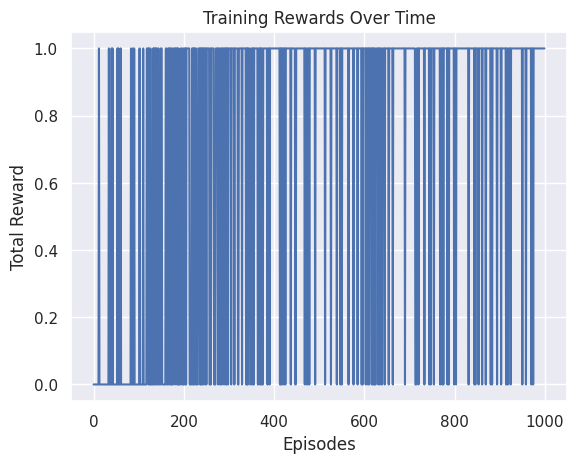

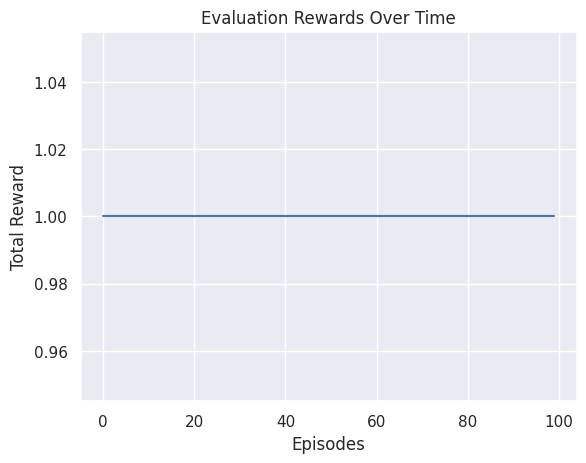

Testing alpha=0.1, gamma=0.9, epsilon=0.1
Average reward: 0.0
Testing alpha=0.1, gamma=0.9, epsilon=0.3
Average reward: 0.0
Testing alpha=0.1, gamma=0.9, epsilon=0.5
Average reward: 0.0
Testing alpha=0.1, gamma=0.99, epsilon=0.1
Average reward: 0.0
Testing alpha=0.1, gamma=0.99, epsilon=0.3
Average reward: 0.0
Testing alpha=0.1, gamma=0.99, epsilon=0.5
Average reward: 0.0
Testing alpha=0.1, gamma=1.0, epsilon=0.1
Average reward: 0.0
Testing alpha=0.1, gamma=1.0, epsilon=0.3
Average reward: 0.0
Testing alpha=0.1, gamma=1.0, epsilon=0.5
Average reward: 0.0
Testing alpha=0.5, gamma=0.9, epsilon=0.1
Average reward: 0.0
Testing alpha=0.5, gamma=0.9, epsilon=0.3
Average reward: 0.0
Testing alpha=0.5, gamma=0.9, epsilon=0.5
Average reward: 0.0
Testing alpha=0.5, gamma=0.99, epsilon=0.1
Average reward: 0.0
Testing alpha=0.5, gamma=0.99, epsilon=0.3
Average reward: 0.0
Testing alpha=0.5, gamma=0.99, epsilon=0.5
Average reward: 0.0
Testing alpha=0.5, gamma=1.0, epsilon=0.1
Average reward: 0.0
Te

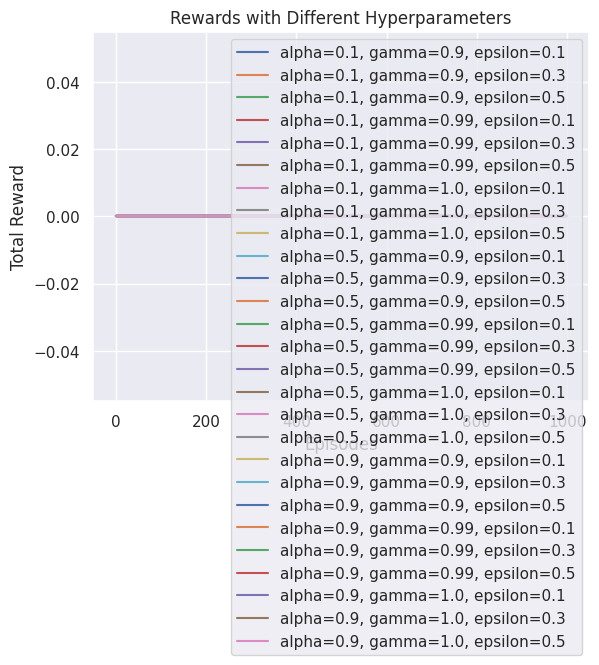

Policy Iteration Average Reward: 1.0


In [28]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# Set a random seed for reproducibility
seed_value = 42

# Step 1: Initialize the environment with a fixed seed
env = gym.make('FrozenLake-v1', is_slippery=False)

# Use the reset method to set the seed for the environment
env.reset(seed=seed_value)

# Seed numpy for reproducibility in the Q-learning process
np.random.seed(seed_value)

# Q-learning hyperparameters
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_decay = 0.995
min_epsilon = 0.1
episodes = 1000
max_steps = 100  # Max steps per episode

# Step 2: Initialize Q-table
state_space_size = env.observation_space.n
action_space_size = env.action_space.n
q_table = np.zeros((state_space_size, action_space_size))

# Step 3: Training Q-learning agent
def train_q_learning(env, q_table, alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps):
    rewards = []
    for episode in range(episodes):
        state, _ = env.reset()  # Get initial state
        done = False
        total_reward = 0

        for _ in range(max_steps):
            if np.random.rand() < epsilon:  # Exploration
                action = env.action_space.sample()
            else:  # Exploitation
                action = np.argmax(q_table[state, :])

            next_state, reward, done, truncated, _ = env.step(action)

            # Q-learning update rule
            q_table[state, action] = q_table[state, action] + alpha * (reward + gamma * np.max(q_table[next_state, :]) - q_table[state, action])

            state = next_state
            total_reward += reward

            if done:
                break

        epsilon = max(min_epsilon, epsilon * epsilon_decay)  # Decay epsilon
        rewards.append(total_reward)

    return q_table, rewards

# Train the Q-learning agent
q_table, training_rewards = train_q_learning(env, q_table, alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)

# Step 4: Evaluate the performance of the trained agent
def evaluate_agent(env, q_table, episodes=100):
    total_rewards = []
    for _ in range(episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = np.argmax(q_table[state, :])  # Exploit the learned policy
            next_state, reward, done, truncated, _ = env.step(action)
            state = next_state
            total_reward += reward

        total_rewards.append(total_reward)

    return total_rewards

# Evaluate the agent
evaluation_rewards = evaluate_agent(env, q_table)

# Step 5: Visualize training rewards
plt.plot(training_rewards)
plt.title("Training Rewards Over Time")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.show()

# Step 6: Visualize evaluation rewards
plt.plot(evaluation_rewards)
plt.title("Evaluation Rewards Over Time")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.show()

# Step 7: Testing different hyperparameters
def test_different_hyperparameters():
    alpha_values = [0.1, 0.5, 0.9]
    gamma_values = [0.9, 0.99, 1.0]
    epsilon_values = [0.1, 0.3, 0.5]

    for alpha in alpha_values:
        for gamma in gamma_values:
            for epsilon in epsilon_values:
                print(f"Testing alpha={alpha}, gamma={gamma}, epsilon={epsilon}")
                q_table = np.zeros((state_space_size, action_space_size))
                q_table, rewards = train_q_learning(env, q_table, alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
                print(f"Average reward: {np.mean(rewards)}")
                plt.plot(rewards, label=f"alpha={alpha}, gamma={gamma}, epsilon={epsilon}")

    plt.title("Rewards with Different Hyperparameters")
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.show()

# Test different hyperparameters
test_different_hyperparameters()

# Step 8: Policy Iteration Algorithm (corrected version)
def policy_iteration(env, gamma=0.99, episodes=1000):
    policy = np.zeros(env.observation_space.n, dtype=int)
    value_function = np.zeros(env.observation_space.n)

    for _ in range(episodes):
        # Policy Evaluation: Calculate value function based on current policy
        for state in range(env.observation_space.n):
            action = policy[state]
            # Simulate the next state transition
            next_state, reward, done, truncated, _ = env.step(action)
            value_function[state] = reward + gamma * value_function[next_state]

        # Policy Improvement: Update policy based on value function
        for state in range(env.observation_space.n):
            q_values = []
            for action in range(env.action_space.n):
                next_state, reward, done, truncated, _ = env.step(action)
                q_values.append(reward + gamma * value_function[next_state])
            policy[state] = np.argmax(q_values)

    return policy, value_function

# Run policy iteration
policy, value_function = policy_iteration(env)

# Compare Q-learning and policy iteration performance
policy_rewards = evaluate_agent(env, q_table)
print(f"Policy Iteration Average Reward: {np.mean(policy_rewards)}")


In [33]:
import gymnasium as gym

# List all available environments
envs = gym.envs.registry
for env in envs:
    print(env)


CartPole-v0
CartPole-v1
MountainCar-v0
MountainCarContinuous-v0
Pendulum-v1
Acrobot-v1
phys2d/CartPole-v0
phys2d/CartPole-v1
phys2d/Pendulum-v0
LunarLander-v3
LunarLanderContinuous-v3
BipedalWalker-v3
BipedalWalkerHardcore-v3
CarRacing-v3
Blackjack-v1
FrozenLake-v1
FrozenLake8x8-v1
CliffWalking-v0
Taxi-v3
tabular/Blackjack-v0
tabular/CliffWalking-v0
Reacher-v2
Reacher-v4
Reacher-v5
Pusher-v2
Pusher-v4
Pusher-v5
InvertedPendulum-v2
InvertedPendulum-v4
InvertedPendulum-v5
InvertedDoublePendulum-v2
InvertedDoublePendulum-v4
InvertedDoublePendulum-v5
HalfCheetah-v2
HalfCheetah-v3
HalfCheetah-v4
HalfCheetah-v5
Hopper-v2
Hopper-v3
Hopper-v4
Hopper-v5
Swimmer-v2
Swimmer-v3
Swimmer-v4
Swimmer-v5
Walker2d-v2
Walker2d-v3
Walker2d-v4
Walker2d-v5
Ant-v2
Ant-v3
Ant-v4
Ant-v5
Humanoid-v2
Humanoid-v3
Humanoid-v4
Humanoid-v5
HumanoidStandup-v2
HumanoidStandup-v4
HumanoidStandup-v5
GymV21Environment-v0
GymV26Environment-v0


In [36]:
pip install swig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.2 MB/s eta 0:00:00


In [38]:
pip install "gymnasium[box2d]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376418 sha256=0da516ddc5a458cfefee8899ffec4ef077543f8ab0022b0b98a82985cb5b1854
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [43]:
import gymnasium as gym
import numpy as np

# Initialize the environment
env = gym.make('CarRacing-v3')
env.reset()

# Discretization function: Convert continuous actions into discrete bins
def discretize_action(action, steering_bins=3, throttle_bins=2):
    # Discretize steering (3 levels: -1, 0, 1)
    steering = np.digitize(action[0], np.linspace(-1, 1, steering_bins)) - 1  # -1, 0, 1

    # Discretize throttle (2 levels: 0, 1)
    throttle = np.digitize(action[1], np.linspace(0, 1, throttle_bins)) - 1  # 0, 1

    return (steering, throttle)

# Example usage
action = np.array([0.5, 0.2])  # continuous action [steering, throttle]
discretized_action = discretize_action(action)
print(f"Discretized action: {discretized_action}")


Discretized action: (1, 0)


In [58]:
def train_dqn(env, q_network, episodes, gamma, epsilon, epsilon_decay, min_epsilon, batch_size):
    rewards = []
    memory = deque(maxlen=10000)  # Experience replay memory
    optimizer = tf.optimizers.Adam()  # Optimizer for training the Q-network
    loss_fn = tf.losses.MeanSquaredError()  # Loss function for training

    for episode in range(episodes):
        state, info = env.reset()  # Adjust to unpack the correct values (state, info)
        state = preprocess_frame(state)  # Preprocess the first frame
        done = False
        total_reward = 0
        epsilon = max(min_epsilon, epsilon * epsilon_decay)  # Decay epsilon

        while not done:
            # Exploration vs. exploitation
            if np.random.rand() < epsilon:
                action = env.action_space.sample()  # Random action (exploration)
            else:
                action = np.argmax(q_network(np.expand_dims(state, axis=0)))  # Action with highest Q-value (exploitation)

            # Take action and observe the next state and reward
            next_state, reward, done, _, _ = env.step(action)
            next_state = preprocess_frame(next_state)  # Preprocess the next frame

            # Store the transition in memory
            memory.append((state, action, reward, next_state, done))

            # Ensure memory consistency before sampling
            if len(memory) > batch_size:
                # Sample a batch from memory
                batch = random.sample(memory, batch_size)  # Sample a random batch
                states, actions, rewards, next_states, dones = zip(*batch)
                states = np.array(states)
                next_states = np.array(next_states)

                # Compute Q-values for the next state
                target_q_values = q_network(next_states)
                next_q_values = np.max(target_q_values, axis=1)
                target = np.array(rewards) + gamma * next_q_values * (1 - np.array(dones))

                # Compute the current Q-values for the current states
                with tf.GradientTape() as tape:
                    q_values = q_network(states)
                    action_q_values = tf.gather(q_values, np.array(actions), axis=1, batch_dims=1)
                    loss = tf.reduce_mean(loss_fn(target, action_q_values))

                # Update the Q-network
                grads = tape.gradient(loss, q_network.trainable_variables)
                optimizer.apply_gradients(zip(grads, q_network.trainable_variables))

            # Update state and total reward
            state = next_state
            total_reward += reward

        rewards.append(total_reward)

        if episode % 100 == 0:
            print(f"Episode {episode}/{episodes}, Total Reward: {total_reward}, Epsilon: {epsilon}")

    return rewards


In [61]:
import gym
import numpy as np
import tensorflow as tf
import random
from collections import deque

# Preprocess the frame: Normalize and resize
def preprocess_frame(frame):
    # Since CartPole has a small state space (4 values), no need for resizing or complex preprocessing
    # Normalize state if needed (optional)
    frame = frame / 255.0
    return frame

# Define Q-network model (fully connected for CartPole)
def create_q_network(input_shape, num_actions):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),  # input layer
        tf.keras.layers.Dense(64, activation='relu'),  # hidden layer
        tf.keras.layers.Dense(64, activation='relu'),  # hidden layer
        tf.keras.layers.Dense(num_actions, activation='linear')  # output layer: Q-values for each action
    ])
    return model

# Train DQN agent
def train_dqn(env, q_network, episodes, gamma, epsilon, epsilon_decay, min_epsilon, batch_size):
    rewards = []
    memory = deque(maxlen=10000)  # Experience replay memory
    optimizer = tf.optimizers.Adam()  # Optimizer for training the Q-network
    loss_fn = tf.losses.MeanSquaredError()  # Loss function for training

    for episode in range(episodes):
        state = env.reset()  # Reset and get initial state (no need to unpack)
        state = preprocess_frame(state)  # Preprocess the first frame
        done = False
        total_reward = 0
        epsilon = max(min_epsilon, epsilon * epsilon_decay)  # Decay epsilon

        while not done:
            # Exploration vs. exploitation
            if np.random.rand() < epsilon:
                action = env.action_space.sample()  # Random action (exploration)
            else:
                action = np.argmax(q_network(np.expand_dims(state, axis=0)))  # Action with highest Q-value (exploitation)

            # Take action and observe the next state and reward
            next_state, reward, done, _, _ = env.step(action)
            next_state = preprocess_frame(next_state)  # Preprocess the next frame

            # Store the transition in memory
            memory.append((state, action, reward, next_state, done))

            # Ensure memory consistency before sampling
            if len(memory) > batch_size:
                # Sample a batch from memory
                batch = random.sample(memory, batch_size)  # Sample a random batch
                states, actions, rewards, next_states, dones = zip(*batch)
                states = np.array(states)
                next_states = np.array(next_states)

                # Compute Q-values for the next state
                target_q_values = q_network(next_states)
                next_q_values = np.max(target_q_values, axis=1)
                target = np.array(rewards) + gamma * next_q_values * (1 - np.array(dones))

                # Compute the current Q-values for the current states
                with tf.GradientTape() as tape:
                    q_values = q_network(states)
                    action_q_values = tf.gather(q_values, np.array(actions), axis=1, batch_dims=1)
                    loss = tf.reduce_mean(loss_fn(target, action_q_values))

                # Update the Q-network
                grads = tape.gradient(loss, q_network.trainable_variables)
                optimizer.apply_gradients(zip(grads, q_network.trainable_variables))

            # Update state and total reward
            state = next_state
            total_reward += reward

        rewards.append(total_reward)

        if episode % 100 == 0:
            print(f"Episode {episode}/{episodes}, Total Reward: {total_reward}, Epsilon: {epsilon}")

    return rewards

# Initialize the environment
env = gym.make('CartPole-v1')  # Example: CartPole environment
input_shape = env.observation_space.shape  # Shape (4,)
num_actions = env.action_space.n  # Number of possible actions

# Create Q-network
q_network = create_q_network(input_shape=input_shape, num_actions=num_actions)

# Hyperparameters
episodes = 1000
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
min_epsilon = 0.1
batch_size = 64

# Train the agent
rewards = train_dqn(env, q_network, episodes, gamma, epsilon, epsilon_decay, min_epsilon, batch_size)

# Optionally: Save the trained model
q_network.save("trained_dqn_model.h5")

# After training, you can evaluate the agent or visualize its performance


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


ValueError: not enough values to unpack (expected 5, got 4)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting rewards over episodes
def plot_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Progress - DQN on CartPole')
    plt.show()

# Run the trained agent and visualize its performance
def visualize_agent(env, q_network, episodes=10):
    total_rewards = []

    for episode in range(episodes):
        state = env.reset()  # Reset environment
        state = preprocess_frame(state)  # Preprocess the state
        done = False
        total_reward = 0

        while not done:
            # Select the action with the highest Q-value
            action = np.argmax(q_network(np.expand_dims(state, axis=0)))  # Exploitation
            next_state, reward, done, _, _ = env.step(action)  # Take the action
            next_state = preprocess_frame(next_state)  # Preprocess the next state
            state = next_state  # Update the state
            total_reward += reward  # Add the reward

            env.render()  # Render the environment to visualize the agent's actions

        total_rewards.append(total_reward)
        print(f"Episode {episode + 1}/{episodes} - Total Reward: {total_reward}")

    # Plot total rewards for visualization
    plt.plot(total_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Agent Performance in CartPole-v1')
    plt.show()

# Visualize agent's performance after training
visualize_agent(env, q_network, episodes=10)


In [67]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from collections import deque
import random

# Hyperparameters
gamma = 0.99  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_min = 0.1  # Minimum exploration rate
epsilon_decay = 0.995  # Exploration decay factor
learning_rate = 0.00025  # Learning rate for optimizer
batch_size = 32  # Size of mini-batch for experience replay
memory_size = 100000  # Size of the experience replay memory
target_update = 10  # How often to update the target network

# Select the environment
env = gym.make('CartPole-v1')  # Use CartPole-v1 (discrete action space)

# Preprocess the frames (normalize and reshape)
def preprocess_state(state):
    return np.reshape(state, [1, env.observation_space.shape[0]])

# Build the Q-network (MLP for CartPole)
def create_q_network(input_shape, num_actions):
    model = tf.keras.Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.Dense(24, activation='relu'),
        layers.Dense(24, activation='relu'),
        layers.Dense(num_actions, activation='linear')  # Q-values for each action
    ])
    return model

# Experience Replay Buffer
class ExperienceReplay:
    def __init__(self, memory_size):
        self.memory = deque(maxlen=memory_size)

    def store(self, experience):
        self.memory.append(experience)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def size(self):
        return len(self.memory)

    # Q-learning with deep neural network (DQN)
    def train_dqn(env, q_network, target_network, episodes=500, gamma=0.99, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.995, batch_size=32):
        memory = ExperienceReplay(memory_size=100000)
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        total_rewards = []
        episode_durations = []

        for episode in range(episodes):
            state = env.reset()
            state = preprocess_state(state)  # Preprocess the state
            done = False
            total_reward = 0
            episode_steps = 0

            while not done:
                # Choose action using epsilon-greedy policy
                if np.random.rand() <= epsilon:
                    action = env.action_space.sample()  # Random action
                else:
                    q_values = q_network(state)  # Get Q-values from the network
                    action = np.argmax(q_values)  # Choose action with max Q-value

                # Take action and observe reward
                next_state, reward, done, info = env.step(action)  # Unpack to 4 values
                next_state = preprocess_state(next_state)  # Preprocess next state

                # Store experience in replay buffer
                memory.store((state, action, reward, next_state, done))

                # Update state and accumulate reward
                state = next_state
                total_reward += reward
                episode_steps += 1

                # Train the network if enough experiences are collected
                if memory.size() >= batch_size:
                    batch = memory.sample(batch_size)
                    states, actions, rewards, next_states, dones = zip(*batch)

                    # Convert batch data to tensors
                    states = np.concatenate(states, axis=0)
                    next_states = np.concatenate(next_states, axis=0)
                    actions = np.array(actions)
                    rewards = np.array(rewards)
                    dones = np.array(dones)

                    with tf.GradientTape() as tape:
                        q_values = q_network(states)
                        next_q_values = target_network(next_states)
                        target_q_values = rewards + (1 - dones) * gamma * np.max(next_q_values, axis=1)

                        # Calculate the loss (Mean Squared Error)
                        q_values = tf.reduce_sum(q_values * tf.one_hot(actions, env.action_space.n), axis=1)
                        loss = tf.reduce_mean(tf.square(target_q_values - q_values))

                    # Backpropagate and update weights
                    grads = tape.gradient(loss, q_network.trainable_variables)
                    optimizer.apply_gradients(zip(grads, q_network.trainable_variables))

            # Update the target network every few episodes
            if episode % target_update == 0:
                target_network.set_weights(q_network.get_weights())

            # Decrease epsilon for exploration-exploitation balance
            if epsilon > epsilon_min:
                epsilon *= epsilon_decay

            total_rewards.append(total_reward)
            episode_durations.append(episode_steps)

            print(f"Episode {episode+1}/{episodes} - Total Reward: {total_reward}, Duration: {episode_steps}, Epsilon: {epsilon}")

        return total_rewards, episode_durations


# Initialize the Q-network and target network
input_shape = (env.observation_space.shape[0],)  # CartPole state space shape (4,)
num_actions = env.action_space.n  # Number of actions in CartPole (2 actions)
q_network = create_q_network(input_shape, num_actions)
target_network = create_q_network(input_shape, num_actions)

# Train the agent
rewards, durations = train_dqn(env, q_network, target_network, episodes=500)

# Plot rewards
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()

# Plot episode durations
plt.plot(durations)
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.title('Episode Duration')
plt.show()


ValueError: not enough values to unpack (expected 5, got 4)